In [108]:
import geopandas as gpd
import pandas as pd
from pandas.io.json import json_normalize
import urllib.request
import json
from geopandas import GeoDataFrame
from shapely.geometry import Point
from datetime import datetime, timedelta
import subprocess as sp
%matplotlib inline

In [109]:
# cmd function, input is a comma separated list of items
def cmd(command):
    print (sp.list2cmdline(command))
    norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
    norm.communicate()

In [2]:
def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ElementTree.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

In [3]:
def convert_coordinates(coordinates, srcEPSG, dstEPSG):
    """
    Converts points to coordinatesystem
    
    Input:
    coordinates: (list of) tuples
    """    
    from osgeo.osr import SpatialReference, CoordinateTransformation

    src = SpatialReference()
    dst = SpatialReference()
    
    src.ImportFromEPSG(srcEPSG)
    dst.ImportFromEPSG(dstEPSG)
    
    transform = CoordinateTransformation(src, dst)

    if not type(coordinates) is list:
        coordinates = [(coordinates)]
       
    if len(coordinates[0]) == 2:
        dimension = 2
    else:
        dimension = 3
       
    transformed = []
    for crd in coordinates:
        transformed.append((transform.TransformPoint(*crd)))
    
    if dimension == 2:
        transformed = [(i[0], i[1]) for i in transformed]
    return transformed

In [4]:
# set timedelta in epoch
min_timedelta = 0
time_epoch = int((datetime.now() - timedelta(minutes=min_timedelta)).timestamp())
print ((datetime.now() - timedelta(minutes=min_timedelta)).strftime('%c'))
print (time_epoch)

Wed Jun  7 13:21:00 2017
1496834460


In [6]:
# GET PORTS IN EUROPA
# urls to retrieve AIS data from data providers
#url_marinetraffic  = 'https://www.marinetraffic.com/getData/get_data_json_4/z:5/X:7/Y:4/station:0'
minlat = str(48)
maxlat = str(59)
minlon = str(-19)
maxlon = str(18)
timecode = str(time_epoch)
mmsi = str(244660778)
zoom = str(6)
#http://www.myshiptracking.com/requests/vesselsonmap.php?type=json&minlat=48.21090391809528&maxlat=59.612873953800104&minlon=-19.035536508636483&maxlon=17.988389272613517&zoom=6&mmsi=null&timecode=0
url_portsinEU = 'http://www.myshiptracking.com/requests/vesselsonmap.php?type=json&minlat='+minlat+'&maxlat='+maxlat+'&minlon='+minlon+'&maxlon='+maxlon+'&zoom='+zoom+'&mmsi='+mmsi+'&timecode='+timecode
print (url_portsinEU)

http://www.myshiptracking.com/requests/vesselsonmap.php?type=json&minlat=48&maxlat=59&minlon=-19&maxlon=18&zoom=6&mmsi=244660778&timecode=1496834460


In [7]:
# request the tracking url and decode as json and parse to pandas dataframe
r = urllib.request.urlopen(url_portsinEU)
data = json.loads(r.read().decode(r.info().get_param('charset') or 'utf-8'))
df_portsinEU = json_normalize(data[0]['PORTS'])

In [8]:
df_portsinEU.shape

(974, 4)

In [9]:
# drop all the NaNs
# and convert strings to floats
df_portsinEU.dropna(inplace=True)
df_portsinEU.LNG = df_portsinEU.LNG.astype(float)
df_portsinEU.LAT = df_portsinEU.LAT.astype(float)
#df_portsinEU

In [9]:
# vessels
import folium

mapa = folium.Map([52.419052, 4.800132],
                  zoom_start=int(zoom),
                  tiles='cartodbpositron')

fg=folium.FeatureGroup(name="ships")
#points = folium.features.GeoJson(df)

for lat,lon,name,id_ in zip(df_portsinEU['LAT'],df_portsinEU['LNG'],df_portsinEU['N'],df_portsinEU['ID']):
    #print (lat,lon,name,id_)
    try:
        #print(lat,lon)
        fg.add_child(folium.Marker(location=[lat,lon]))#,popup=(folium.Popup('NAME: '+name+'  ')))
    except:
        continue

mapa.add_child(fg)
mapa.add_child(folium.LayerControl())

In [23]:
# GET VESSELS IN NZK_ARK
# urls to retrieve AIS data from data providers
#url_marinetraffic  = 'https://www.marinetraffic.com/getData/get_data_json_4/z:5/X:7/Y:4/station:0'
minlat = str(52.316734)
maxlat = str(52.476281)
minlon = str(4.422955)
maxlon = str(5.059489)
timecode = str(time_epoch)
mmsi = str(244660778)
zoom = str(10)

url_vesselsonmap = 'http://www.myshiptracking.com/requests/vesselsonmap.php?type=json&minlat='+minlat+'&maxlat='+maxlat+'&minlon='+minlon+'&maxlon='+maxlon+'&zoom='+zoom+'&mmsi='+mmsi+'&timecode='+timecode
print (url_vesselsonmap)

# request the tracking url and decode as json and parse to pandas dataframe
r = urllib.request.urlopen(url_vesselsonmap)
data = json.loads(r.read().decode(r.info().get_param('charset') or 'utf-8'))
df_vesselsonmap = json_normalize(data[0]['DATA'])

# drop all the NaNs
# and convert strings to floats
df_vesselsonmap.dropna(inplace=True)
df_vesselsonmap.LNG = df_vesselsonmap.LNG.astype(float)
df_vesselsonmap.LAT = df_vesselsonmap.LAT.astype(float)

## convert LNG and LAT columns to geodataframe
# geometry = [Point(xy) for xy in zip(df.LNG.astype(float), df.LAT.astype(float))]
# df = df.drop(['LNG', 'LAT'], axis=1)
# crs = {'init': 'epsg:4326'}
# geo_df = GeoDataFrame(df, crs=crs, geometry=geometry)

print (df_vesselsonmap.shape)

http://www.myshiptracking.com/requests/vesselsonmap.php?type=json&minlat=52.316734&maxlat=52.476281&minlon=4.422955&maxlon=5.059489&zoom=10&mmsi=244660778&timecode=1496834460
(157, 17)


In [24]:
# vessels
import folium

mapa = folium.Map([52.419052, 4.800132],
                  zoom_start=int(zoom),
                  tiles='cartodbpositron')

fg=folium.FeatureGroup(name="ships")
#points = folium.features.GeoJson(df)

for lat,lon,name,dest in zip(df_vesselsonmap['LAT'],df_vesselsonmap['LNG'],df_vesselsonmap['NAME'],df_vesselsonmap['DEST']):
    #print (lat,lon,name,dest)
    try:
        fg.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup('NAME: '+name+'  '+'DEST: '+dest))))
    except:
        continue

mapa.add_child(fg)
mapa.add_child(folium.LayerControl())

In [25]:
# REQUEST SINGLE SHIP INFORMATION

In [27]:
def getVesselDetails(mmsi):
    # urls to retrieve AIS data from data providers
    # mmsi (type: string)

    url_vesseldetails = 'http://www.myshiptracking.com/requests/vesseldetails.php?type=json&mmsi='+mmsi
    #print (url_vesseldetails)

    # request the tracking url and decode as json and parse to pandas dataframe
    r = urllib.request.urlopen(url_vesseldetails)
    data = json.loads(r.read().decode(r.info().get_param('charset') or 'utf-8'))
    df_vesseldetails = json_normalize(data)
    
    # define width and height of boat
    try:
        df_vesseldetails['HKV.LENGTH'] = float(df_vesseldetails['V.TO_BOW']) + float(df_vesseldetails['V.TO_STERN'])
        df_vesseldetails['HKV.WIDTH']  = float(df_vesseldetails['V.TO_STARBOARD']) + float(df_vesseldetails['V.TO_PORT'])
    except Exception as e:
        print (e)
        
    # define RD coordinates of boat
    try:
        rd_coords = convert_coordinates([(float(df_vesseldetails['V.LNG']),float(df_vesseldetails['V.LAT']))], 4326, 28992)[0]
        #print (rd_coords)
        df_vesseldetails['HKV.RD_X'] = rd_coords[0]
        df_vesseldetails['HKV.RD_Y'] = rd_coords[1]
    except Exception as e:
        print (e)
    return df_vesseldetails

In [28]:
# get single mmsi to get structure of the series
mmsi = str(df_vesselsonmap['MMSI'].iloc[0])
print (mmsi)
base_df_vDetails = getVesselDetails(mmsi)

992446026


In [29]:
#base_df_vDetails.T

In [30]:
# iterate over all vessels to get detailed vessel information
for mmsi in df_vesselsonmap['MMSI'].iloc[1::]:
    print (str(mmsi))
    df_vDetails = getVesselDetails(str(mmsi))
    # concatenate all vessel information to one single dataframe 
    # its slow method as it is copying over the dataframe each time it concatentates..
    base_df_vDetails = pd.concat([base_df_vDetails, df_vDetails], axis=0)
base_df_vDetails.reset_index(inplace=True)
base_df_vDetails.drop(base_df_vDetails.columns[0], axis=1, inplace=True)

992446020
244670014
244850073
244670699
244730478
2442024
could not convert string to float: 
244670128
244670989
244045000
244660320
244020449
255805596
212710000
266310000
236112059
245279000
548909000
244670616
244100389
244700496
244573182
244660659
244630541
244660235
244660441
244750124
235108533
477627200
258430000
231695000
992441005
992446002
992446004
257433000
477201500
2444012
244820297
244890219
244700948
244700463
244850548
245351000
235010670
244750434
244740162
244820092
372580000
1229456
2444010
205530290
244100057
211386900
244030715
244820226
244780962
227654770
211706940
244670291
244650786
244750576
244740850
244670119
244615958
244820397
244620567
244660974
244700178
244710890
244670460
244615365
244670312
244710229
205379090
245137000
244850180
244690414
244850641
245447000
244770122
244020025
226003920
244020812
244660554
244730166
244020560
246310000
244750693
244780845
244700472
244770199
244730671
244710346
244710638
246124000
244660783
244650941
244060306
24

In [31]:
base_df_vDetails.shape

(157, 29)

In [32]:
base_df_vDetails.reset_index(inplace=True)
base_df_vDetails.drop(base_df_vDetails.columns[0], axis=1, inplace=True)
base_df_vDetails.head()

,HKV.LENGTH,HKV.RD_X,HKV.RD_Y,HKV.WIDTH,P,TZ,V.COG,V.DESTINATION,V.DRAUGHT,V.ETA,...,V.RECEIVED_AGO,V.RECEIVED_SEC,V.RECEIVED_STATIC,V.SOG,V.STATION_ID,V.TO_BOW,V.TO_PORT,V.TO_STARBOARD,V.TO_STERN,V.VESSEL_TYPE
0,112.0,73798.653122,512145.834716,112.0,[],,0,,,,...,32 sec ago,32.4226498,2017-06-07 11:21,0,14,56,56,56,56,Navigation Aid
1,112.0,77342.537912,513634.212160,112.0,[],,0,,,,...,55 sec ago,55.1888203,2017-06-07 11:21,0,14,56,56,56,56,Navigation Aid
2,40.0,112328.502016,515722.886976,6.0,[],,511,,0.2,,...,13 sec ago,13.9222098,2017-06-07 10:03,0,14,34,4,2,6,Not available
3,80.0,112898.922288,513470.170971,8.0,[{'LINK': 'port-of-zaandam-in-nl-netherlands-i...,,198.9,,0.3,,...,23 sec ago,23.3599332,2017-06-07 11:18,6.9,14,68,1,7,12,Not available
4,85.0,132661.587821,513748.630277,10.0,[{'LINK': 'port-of-hoorn-in-nl-netherlands-id-...,,15.1,HOORN,1.9,2017-07-06 14:00 UTC,...,8 sec ago,8.2189478,2017-06-07 11:19,5.7,14,35,6,4,50,Not available


In [33]:
NZK_ARK_model = gpd.read_file(r'D:\Projects\RO\0708.10.00\hackathon\NZK_ARK_model.shp')
NZK_ARK_model

,edge,geometry,id,node_1,node_2
0,HPTtoSIO,"LINESTRING (102303 498014, 115715.0295549681 4...",1,SIO,HPT
1,OSZtoGMC,LINESTRING (125834.8385242207 488097.960318209...,2,GMC,OSZ
2,GMCtoHPT,LINESTRING (125097.1113399494 487542.143220960...,3,HPT,GMC
3,HHNtoHPT,LINESTRING (115956.4334116898 489974.148884884...,10,HPT,HNN
4,PIZtoLKD,LINESTRING (150411.4822972389 442071.749989498...,4,PIZ,LKD
5,PBStoLKD,LINESTRING (135991.0935161071 447344.515273892...,5,PBS,LKD
6,LKDtoGMC,"LINESTRING (136165.27718886 449874.7760399714,...",6,LK,GMC
7,SIJtoNZN,"LINESTRING (97218 497960, 71485.07769248312 56...",7,SIJ,NZN
8,SIJtoNZW,LINESTRING (28392.35379833178 505374.471479531...,9,SIJ,NZW
9,SIJtoNZZ,"LINESTRING (97218 497960, -19654.88357901157 4...",8,SIJ,NZZ


In [97]:
buffer = NZK_ARK_model.buffer(100000).unary_union

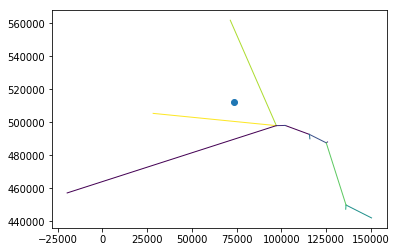

In [98]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
NZK_ARK_model.plot(ax=ax)
plt.scatter(*Point(base_df_vDetails.iloc[0][['HKV.RD_X','HKV.RD_Y']]).coords[0])
#NZK_ARK_model.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156


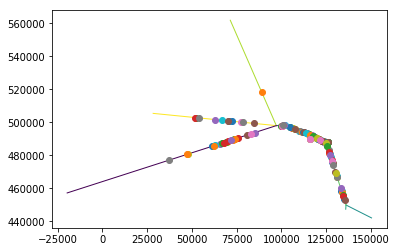

In [99]:
import numpy as np

fig, ax = plt.subplots()
NZK_ARK_model.plot(ax=ax)

base_df_vDetails['HKV.START_EDGE'] = ""

list_ix = []
for ix, row in base_df_vDetails.iterrows():
    print (ix)
    pt = Point(row[['HKV.RD_X','HKV.RD_Y']])
    if buffer.intersects(pt) == True:
        # append all vessels that are within model distance to list
        list_ix.append(ix)        
        
        # get closest edge for vessel
        idxmin = np.argmin(NZK_ARK_model.distance(pt))
        channel = NZK_ARK_model.loc[idxmin]
        #print ('edge: ',channel)
        base_df_vDetails.loc[(base_df_vDetails.index==ix),'HKV.START_EDGE'] = channel.edge
#         base_df_vDetails.ix[ix]['V.START_EDGE'] = channel.edge
        
        # get location on edge
        snappedpt = channel['geometry'].interpolate(channel['geometry'].project(pt))
        #print (channel.edge, channel['geometry'].project(pt), channel['geometry'].interpolate(channel['geometry'].project(pt)))
        
#         ax.plot(zip(pt.coords[0], ))
        ax.plot(*snappedpt.coords[0], marker='o')

In [100]:
# create new dataframe with vessels within buffer
df_vDetails_sel_buffer = base_df_vDetails.ix[list_ix]
df_vDetails_sel_buffer.reset_index(inplace=True)
df_vDetails_sel_buffer.drop('index', axis=1,inplace=True)

In [101]:
df_vDetails_sel_buffer.shape

(156, 30)

In [102]:
# create two lists to match destinations with ports
ports = df_portsinEU['N'].tolist()
destinations = df_vDetails_sel_buffer['V.LDEST'].tolist()

In [105]:
import random
# long version with index
match_ports = []
match_idx_d = []
for idx_d, dest in enumerate(destinations):
#     for idx_p, port in enumerate(ports):
    if dest in ports:
        print (dest)
        match_idx_d.append(idx_d)
        match_ports.append(dest)
#             print (idx_d, dest, idx_p, port)
    if not dest in ports:
        #print (dest)
        match_idx_d.append(idx_d)
        port_unknown = random.choice(ports)
        print ('||',port_unknown)
        match_ports.append(port_unknown)            

|| NIEUWEGEIN
|| TRABZON
|| KINLOCH
HOORN
|| VASTERAS
HOORN
|| MARMARI
|| LINDOE
|| SANDOWN
|| VOULIAGMENI
|| OSLO
AMSTERDAM
|| MOLENE
KASKINEN
|| LOUTRA
ROTTERDAM
|| DORPEN
IJMUIDEN
|| CULLERA
URK
|| HANSWEERT
|| EVANTON
|| GILLS
|| LONDONDERRY
|| LAVRIO
|| NYBORG
|| PEMBROKE
|| CIUTADELLA DE MENORC
|| MARSEILLE
ABERDEEN
LE HAVRE
|| SPODSBJERG
|| VAKFIKEBIR
|| GILLS
|| ALTA
|| SOUTHWOLD
|| PLYMOUTH
|| BREST
|| LA SEYNE-SUR-MER
|| SCARIO
|| PORTAVOGIE
|| CAIRNRYAN
|| GULLUK
|| NAVEKVARN
|| INVERNESS
|| ARNIS
|| LE HAVRE
|| ORDU
|| MOLOS
|| BRIXHAM
|| PORT VENDRES
|| HARLINGEN
ROTTERDAM
|| HALLUM
|| KATAPOLA
|| AMALIAPOLI
TRIER
WAGENINGEN
|| AMELAND
|| METZ
|| KIPARISSI MITROPOLI
|| MAASBRACHT
|| AYVALIK
|| COWES
AMSTERDAM
|| SPLIT
|| STAVSNAS
|| TUZLA
|| BARI
ROTTERDAM
|| ORNO
|| ONDARROA
EEMSHAVEN
|| QUIBERON
|| AEGINA
URK
|| HYDRA
|| PORTO EMPEDOCLE
|| FOCA
|| BAYONNE
|| MAASBOMMEL
|| KRISTIANSUND
|| ARTLENBURG
|| IRAKLIA
MONNICKENDAM
|| STRAUBING
|| CANVEY ISLAND
|| CHERBOURG
|| FOR

In [80]:
# set END_DESTINATION with name of port
# select dataframe that contain these matches
df_vDetails_sel_buffer['HKV.END_DESTINATION'] = ""
df_vDetails_sel_buffer['HKV.END_DESTINATION'].loc[match_idx_d] = match_ports
df_vDetails_sel_match_ports = df_vDetails_sel_buffer.ix[match_idx_d]
df_vDetails_sel_match_ports.reset_index(inplace=True)
df_vDetails_sel_match_ports.drop('index', axis=1,inplace=True)

c:\python35\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [81]:
df_vDetails_sel_match_ports.head()

,HKV.LENGTH,HKV.RD_X,HKV.RD_Y,HKV.WIDTH,P,TZ,V.COG,V.DESTINATION,V.DRAUGHT,V.ETA,...,V.RECEIVED_STATIC,V.SOG,V.STATION_ID,V.TO_BOW,V.TO_PORT,V.TO_STARBOARD,V.TO_STERN,V.VESSEL_TYPE,HKV.START_EDGE,HKV.END_DESTINATION
0,318.0,52522.031522,505643.802222,42.0,[],,199,NLROT,11,2017-06-08 09:00 UTC,...,2017-06-07 11:18,9.6,14,215,21,21,103,Container Ship,SIJtoNZW,KAPELLSKAR
1,95.0,52450.059970,509507.434608,13.0,[{'LINK': 'port-of-schiedam-in-nl-netherlands-...,,181,SCHIEDAM,5.7,2017-06-07 15:00 UTC,...,2017-06-07 09:32,6.4,14,87,6,7,8,General Cargo,SIJtoNZW,KASKINEN
2,144.0,63557.663173,504896.154284,24.0,[{'LINK': 'port-of-rotterdam-in-nl-netherlands...,,269,ROTTERDAM,6.7,2017-06-07 22:00 UTC,...,2017-06-07 11:22,2,14,117,12,12,27,Oil/Chemical Tanker,SIJtoNZW,BOCKHOLMWIK
3,149.0,85317.918723,504528.125937,22.0,[],,254,,6.8,,...,2017-06-07 11:16,1.5,14,117,7,15,32,Oil/Chemical Tanker,SIJtoNZW,ROTTERDAM
4,133.0,77888.181570,504024.841802,15.0,[],,276,,4.7,,...,2017-06-07 11:13,2,14,121,10,5,12,General Cargo,SIJtoNZW,HOLMSUND


In [82]:
df_vDetails_sel_match_ports.shape

(105, 31)

In [83]:
EU_BALLOONS = gpd.read_file(r'D:\Projects\RO\0708.10.00\hackathon\EU_BALLOONS.shp')
EU_BALLOONS

,edge,geometry,id
0,SIJtoNZW,"POLYGON ((18259.22257332731 522855.3731761228,...",1
1,SIJtoNZN,"POLYGON ((69536.79221248554 561612.900784469, ...",2
2,GMCtoOSZ,"POLYGON ((126113.483253862 488456.3693986922, ...",3
3,HPTtoHHN,"POLYGON ((102721.1077021492 514250.9332545416,...",4
4,HPTtoSIO,"POLYGON ((100728.3159429085 511102.5286065924,...",5
5,LKDtoPBS,"POLYGON ((135307.8238118198 447780.9402999919,...",7
6,LKDtoPIZ,"POLYGON ((141981.2097128039 451049.9144436427,...",8
7,SIJtoNZZ,"POLYGON ((-14445.74041001828 467651.019695974,...",9


In [84]:
#df_portsinEU.head()
# convert LNG and LAT columns to geodataframe
geometry = [Point(convert_coordinates(xy, 4326,28992)) for xy in zip(df_portsinEU.LNG, df_portsinEU.LAT)]
df_portsinEU_ = df_portsinEU.drop(['LNG', 'LAT'], axis=1)
crs = {'init': 'epsg:28992'}
geo_df_portsinEU = GeoDataFrame(df_portsinEU_, crs=crs, geometry=geometry)
geo_df_portsinEU = geo_df_portsinEU.to_crs(EU_BALLOONS.crs)

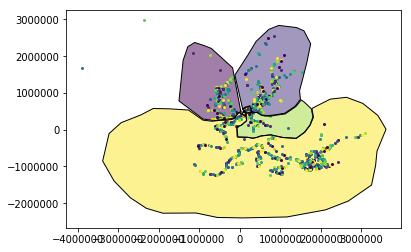

In [85]:
# plot the balloons and ports
fig, ax = plt.subplots()
NZK_ARK_model.plot(ax=ax)
geo_df_portsinEU.plot(ax=ax)
EU_BALLOONS.plot(ax=ax)

In [86]:
from geopandas.tools import sjoin

In [87]:
# make a join of the ports belonging to which balloon to determine exit edge model
ports_in_balloons = sjoin(geo_df_portsinEU, EU_BALLOONS, how='left')
grouped = ports_in_balloons.groupby('index_right')

# drop the ports without corresponding balloon entry [edge]
ports_in_balloons.dropna(inplace=True)

In [88]:
ports_in_balloons

,ID,N,geometry,index_right,edge,id
0,429,TROMSO,POINT (691272.6510081312 2486043.875688397),1.0,SIJtoNZN,2.0
1,88,ALTA,POINT (849513.0788345465 2562736.964407333),1.0,SIJtoNZN,2.0
2,206,HARSTAD,POINT (613456.6896634811 2369313.17587505),1.0,SIJtoNZN,2.0
3,309,NARVIK,POINT (656117.8238537536 2333755.394082645),1.0,SIJtoNZN,2.0
4,280,LOVUND,POINT (471820.8463471651 2070917.376498227),1.0,SIJtoNZN,2.0
5,425,TRAENA,POINT (458176.5684308068 2084974.143446799),1.0,SIJtoNZN,2.0
7,311,NESKAUPSTADUR,POINT (-741395.4497170914 2044715.91699915),0.0,SIJtoNZW,1.0
8,2203,RONNSKAR,POINT (915771.0325293657 1954308.473526922),1.0,SIJtoNZN,2.0
9,331,OULU,POINT (1100876.573434391 2044937.537873717),1.0,SIJtoNZN,2.0
10,353,REYKJAVIK,POINT (-1156931.116308849 2075746.74785171),0.0,SIJtoNZW,1.0


In [89]:
df_vDetails_sel_match_ports['HKV.END_EDGE'] = ""
list_edges = []
for idx, item in df_vDetails_sel_match_ports.iterrows():
    #print (item['HKV.END_DESTINATION'])
    try:
        edge_port = ports_in_balloons[ports_in_balloons['N'] == item['HKV.END_DESTINATION']]['edge'].tolist()[0]
    except Exception as e:
        print (e)
    #print (edge_port)
    list_edges.append(edge_port)
    
df_vDetails_sel_match_ports['HKV.END_EDGE'] = list_edges    

list index out of range


In [90]:
df_vDetails_sel_match_ports[['HKV.START_EDGE','HKV.END_EDGE','HKV.WIDTH','HKV.LENGTH','V.SOG']]

,HKV.START_EDGE,HKV.END_EDGE,HKV.WIDTH,HKV.LENGTH,V.SOG
0,SIJtoNZW,SIJtoNZN,42.0,318.0,9.6
1,SIJtoNZW,SIJtoNZN,13.0,95.0,6.4
2,SIJtoNZW,SIJtoNZN,24.0,144.0,2
3,SIJtoNZW,LKDtoPBS,22.0,149.0,1.5
4,SIJtoNZW,SIJtoNZN,15.0,133.0,2
5,SIJtoNZW,HPTtoSIO,32.0,186.0,0.8
6,HPTtoSIO,SIJtoNZN,5.0,27.0,0.1
7,HPTtoSIO,GMCtoOSZ,6.0,19.0,0
8,HPTtoSIO,SIJtoNZZ,6.0,62.0,0.3
9,SIJtoNZW,SIJtoNZZ,44.0,250.0,7.6


In [91]:
# START CREATING THE TRIPS XML FILE

In [92]:
from xml.etree import ElementTree
from xml.dom import minidom
from xml.etree.ElementTree import Element, SubElement, Comment

In [106]:
# CREATE XML NODES
trips = Element('trips')
for idx,item in df_vDetails_sel_match_ports.iterrows():

    child_1 = SubElement(trips, 'trip')
    child_1.set('id',str(idx))
    child_1.set('depart',str(0))
    child_1.set('from',item['HKV.START_EDGE'])
    child_1.set('to',item['HKV.END_EDGE'])
    child_1.set('type','vessel_'+str(+idx))
print(prettify(trips))

trips_xml = r'C:\Users\Hoek\Sumo\v0.1.0\v0.1.0.tri.xml'
# save xml to file
with open(trips_xml, 'w') as the_file:
    the_file.write(prettify(trips))

<?xml version="1.0" ?>
<trips>
  <trip depart="0" from="SIJtoNZW" id="0" to="SIJtoNZN" type="vessel_0"/>
  <trip depart="0" from="SIJtoNZW" id="1" to="SIJtoNZN" type="vessel_1"/>
  <trip depart="0" from="SIJtoNZW" id="2" to="SIJtoNZN" type="vessel_2"/>
  <trip depart="0" from="SIJtoNZW" id="3" to="LKDtoPBS" type="vessel_3"/>
  <trip depart="0" from="SIJtoNZW" id="4" to="SIJtoNZN" type="vessel_4"/>
  <trip depart="0" from="SIJtoNZW" id="5" to="HPTtoSIO" type="vessel_5"/>
  <trip depart="0" from="HPTtoSIO" id="6" to="SIJtoNZN" type="vessel_6"/>
  <trip depart="0" from="HPTtoSIO" id="7" to="GMCtoOSZ" type="vessel_7"/>
  <trip depart="0" from="HPTtoSIO" id="8" to="SIJtoNZZ" type="vessel_8"/>
  <trip depart="0" from="SIJtoNZW" id="9" to="SIJtoNZZ" type="vessel_9"/>
  <trip depart="0" from="SIJtoNZZ" id="10" to="SIJtoNZZ" type="vessel_10"/>
  <trip depart="0" from="SIJtoNZW" id="11" to="SIJtoNZW" type="vessel_11"/>
  <trip depart="0" from="SIJtoNZW" id="12" to="SIJtoNZZ" type="vessel_12"/>
 

In [94]:
# START CREATING THE ADDITIONAL XML FILE

In [107]:
# CREATE XML NODES
addvsl = Element('additional')
for idx,item in df_vDetails_sel_match_ports.iterrows():

    child_1 = SubElement(addvsl, 'vType')
    child_1.set('id','vessel_'+str(+idx))
    child_1.set('maxSpeed',str(5))
    try:
        if int(item['HKV.LENGTH']) == 0:
            child_1.set('length',str(50))
        else:
            child_1.set('length',str(int(item['HKV.LENGTH'])))
    except:
        child_1.set('length',str(50))
print(prettify(addvsl))

addvsl_xml = r'C:\Users\Hoek\Sumo\v0.1.0\v0.1.0.addvsl.xml'
# save xml to file
with open(addvsl_xml, 'w') as the_file:
    the_file.write(prettify(addvsl))

<?xml version="1.0" ?>
<additional>
  <vType id="vessel_0" length="318" maxSpeed="5"/>
  <vType id="vessel_1" length="95" maxSpeed="5"/>
  <vType id="vessel_2" length="144" maxSpeed="5"/>
  <vType id="vessel_3" length="149" maxSpeed="5"/>
  <vType id="vessel_4" length="133" maxSpeed="5"/>
  <vType id="vessel_5" length="186" maxSpeed="5"/>
  <vType id="vessel_6" length="27" maxSpeed="5"/>
  <vType id="vessel_7" length="19" maxSpeed="5"/>
  <vType id="vessel_8" length="62" maxSpeed="5"/>
  <vType id="vessel_9" length="250" maxSpeed="5"/>
  <vType id="vessel_10" length="97" maxSpeed="5"/>
  <vType id="vessel_11" length="96" maxSpeed="5"/>
  <vType id="vessel_12" length="144" maxSpeed="5"/>
  <vType id="vessel_13" length="220" maxSpeed="5"/>
  <vType id="vessel_14" length="112" maxSpeed="5"/>
  <vType id="vessel_15" length="112" maxSpeed="5"/>
  <vType id="vessel_16" length="135" maxSpeed="5"/>
  <vType id="vessel_17" length="183" maxSpeed="5"/>
  <vType id="vessel_18" length="105" maxSpee

In [110]:
# START CMD SCRIPTS

In [111]:
netconvert = r'C:\Program Files (x86)\DLR\Sumo\bin//netconvert.exe'
duarouter = r'C:\Program Files (x86)\DLR\Sumo\bin//duarouter.exe'
sumo_gui = r'C:\Program Files (x86)\DLR\Sumo\bin//sumo-gui.exe'

In [ ]:
cmd([netconvert, '--node-files=v0.1.0.nod.xml', '--tls.set=SIO,SIW'])

In [ ]:
netconvert --node-files=v0.1.0.nod.xml --tls.set=SIO,SIW --tls.join=true --tls.join-dist=500 --edge-files=v0.1.0.edg.xml --output-file=v0.1.0.net.xml